In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

In [ ]:
import zipfile
archive = zipfile.ZipFile(r'D:\WorkFolder\data\news2017_raw\news2017\201701\01012017-000000-R517858803_htm.zip', 'r')

In [ ]:
files_names = archive.namelist()

In [ ]:
import io
data = io.TextIOWrapper(archive.open(files_names[1]), 'windows-1251').read()

In [ ]:
print(data)

In [ ]:
import pandas as pd
df = pd.DataFrame()

In [ ]:
import os
from tqdm import tqdm

news_dir = r'D:\WorkFolder\data\news2017_raw\news2017'
news_out_dir = r'D:\WorkFolder\data\news2017'
for i, folder in enumerate(os.listdir(news_dir)):
    df = pd.DataFrame()
    documents = []
    
    news_subdir = os.path.join(news_dir, folder)
    for zip_file_name in tqdm(os.listdir(news_subdir)):
        archive_path = os.path.join(news_subdir, zip_file_name)
        archive = zipfile.ZipFile(archive_path, 'r')
        
        for file_name in archive.namelist():
            try:
                data = io.TextIOWrapper(archive.open(file_name), 'windows-1251').read()
            except:
                continue
            documents.append(preprocess_htm(data))
    df['text'] = documents
    df.to_csv(os.path.join(news_out_dir, f'{i}.csv'))

In [ ]:
test_df.shape

In [ ]:
test_df.iloc[0].tolist()[0]

In [ ]:
import re
def preprocess_htm(text):
    text = text.replace('&lt;', '<').replace('&gt;', '>')
    text = re.sub(r'<HTML>(.*?)</NOMORPH>', '', text, flags=re.DOTALL|re.M)
    if '</BODY>' in text:
        text = text[:text.find('</BODY>')]
    text = re.sub(r'<(.*?)>', '', text)
    text = text.strip()
    return text

In [ ]:
print(preprocess_htm(test_df.iloc[2].tolist()[0]))

In [ ]:
test_df['clean_text'] = test_df['raw_htm'].apply(lambda x: preprocess_htm(x))

In [ ]:
print(test_df['clean_text'].sample(1).tolist()[0])

In [ ]:
text = test_df['clean_text'].sample(1).tolist()[0]
print(text)

In [ ]:
' '.join(text.split())

In [1]:
import pymorphy2
from functools import lru_cache

morph_analyzer = pymorphy2.MorphAnalyzer()

@lru_cache(maxsize=1000000)
def get_morph(word):
    return morph_analyzer.parse(word)[0].normal_form

def lemmatize_word(word):
    if word.isdigit() or len(word) < 3:
        return word
    prefix = ''
    suffix = ''
    if word[0] in string.punctuation:
        prefix = word[0]
        word = word[1:]
        
    if word[-1] in string.punctuation:
        suffix = word[-1]
        word = word[:-1]
    
    return prefix + get_morph(word) + suffix

In [2]:
import numpy as np
def corrupt_text(text, frac=0.2):
    splitted_text = text.split()
    seeds = sorted(np.random.choice(range(0, len(splitted_text)), len(splitted_text) // int(1 / frac) + 1, replace=False))
    for i, seed in enumerate(seeds):
        n = min(3, seeds[i + 1] - seed if i < len(seeds) - 1 else len(splitted_text) - seed)
        for j in range(seed, seed + n):
            splitted_text[j] = lemmatize_word(splitted_text[j])
    return ' '.join(splitted_text)

In [3]:
import re
import string
import nltk
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopwords = nltk.corpus.stopwords.words('russian')

In [6]:
def lemmatize_word(word):
    if word.isdigit() or len(word) < 3:
        return word
    prefix = ''
    suffix = ''
    if word[0] in string.punctuation:
        prefix = word[0]
        word = word[1:]
        
    if word[-1] in string.punctuation:
        suffix = word[-1]
        word = word[:-1]
    
    return prefix + get_morph(word) + suffix

In [7]:
import pandas as pd
import os
df_path = r'D:\WorkFolder\data\news2017\0.csv'
df = pd.read_csv(df_path)


In [8]:
df = df.dropna()

In [33]:
from razdel import sentenize

def sentenize_doc(text):
    sentences = []
    text_splitted = [t.strip() for t in text.split('\n') if len(t.strip()) > 0]
    for t in text_splitted:
        sentences += list(s.text for s in sentenize(t))
    return sentences

In [34]:
sentenize_doc(df.iloc[1]['text'])

['На похороны убийцы российского посла пришли тысячи турок',
 'На похороны Мевлют Мерт Алтынташа, убившего российского посла, пришли тысячи людей.',
 'Среди присутствующих были десятки действующих офицеров полиции.',
 'По сообщениям турецких СМИ, на похоронах Мевлют Мерт Алтынташа, полицейского и бывшего сотрудника охраны президента Турции, расстрелявшего посла РФ в Турции Карлова, присутствовало несколько тысяч человек.',
 'На родине убийцы гроб с его телом пронесли на руках по улицам селения, где он родился.',
 'Среди людей на панихиде было много офицеров полиции в форме, которые также пришли почтить память преступника.']

In [35]:
from tqdm import tqdm
sentences = []
for i, row in tqdm(df.iterrows()):
    sentences += sentenize_doc(row['text'])

855211it [03:41, 3853.49it/s]


In [36]:
df = pd.DataFrame()
df['text'] = sentences

In [37]:
from tqdm import tqdm
tqdm.pandas()
df['corrupted_text'] = df['text'].progress_apply(corrupt_text)

100%|███████████████████████████████████████████████████████████████████| 10779942/10779942 [11:18<00:00, 15882.94it/s]


In [41]:
def print_sample(df):
    sample = df.sample(1)
    print(sample['text'].tolist()[0])
    print(sample['corrupted_text'].tolist()[0])

In [52]:
print_sample(df)

Новости по теме При любом использовании материалов НТВ ссылка (для сайтов - гиперссылка на www.ntv.ru ) обязательна.
Новости по теме при любой использование материалов нтв ссылка (для сайтов - гиперссылка на www.ntv.ru ) обязательный.


In [57]:
df['text'][df['text'].apply(lambda x: len(x) > 200)].iloc[0]

'По сообщениям турецких СМИ, на похоронах Мевлют Мерт Алтынташа, полицейского и бывшего сотрудника охраны президента Турции, расстрелявшего посла РФ в Турции Карлова, присутствовало несколько тысяч человек.'

In [58]:
df['corrupted_text'][df['text'].apply(lambda x: len(x) > 200)].iloc[0]

'По сообщениям турецких СМИ, на похоронах мевлютый мерт алтынташ, полицейский и бывший сотрудника охраны президента турция, расстрелять посол РФ в Турции Карлова, присутствовать несколько тысяча человек.'

In [59]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [62]:
tokenizer.decode(tokenizer.encode('По сообщениям турецких СМИ, на похоронах мевлютый мерт алтынташ, полицейский и бывший сотрудника охраны президента турция, расстрелять посол РФ в Турции Карлова, присутствовать несколько тысяча человек.'))

'По сообщениям турецких СМИ, на похоронах мевлютый мерт алтынташ, полицейский и бывший сотрудника охраны президента турция, расстрелять посол РФ в Турции Карлова, присутствовать несколько тысяча человек.</s>'

In [63]:
df['text_tokens_len'] = df['text'].progress_apply(lambda x: len(tokenizer.encode(x)))

100%|████████████████████████████████████████████████████████████████████| 10779942/10779942 [22:42<00:00, 7910.40it/s]


In [77]:
df.to_csv(r'D:\WorkFolder\data\augmentation_data_news2017\0_sentences.csv', index=False)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model.cuda();
model.eval();

def paraphrase(text, beams=5, grams=4, do_sample=False):
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 1.5 + 10)
    out = model.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, max_length=max_size, do_sample=do_sample)
    return tokenizer.decode(out[0], skip_special_tokens=True)

for i in range(10):
    print(paraphrase('Каждый охотник желает знать, где сидит фазан.'))
# Все охотники хотят знать где фазан сидит.

In [ ]:
df.shape[0] // 200 // 50

In [65]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=10100)
val, test = train_test_split(val, test_size=100)
train.shape, val.shape, test.shape


((10769842, 3), (10000, 3), (100, 3))

In [66]:
train.to_csv(r'D:\WorkFolder\data\augmentation_data_news2017\0_sentences_train.csv', index=False)
val.to_csv(r'D:\WorkFolder\data\augmentation_data_news2017\0_sentences_val.csv', index=False)
test.to_csv(r'D:\WorkFolder\data\augmentation_data_news2017\0_sentences_test.csv', index=False)

In [8]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

MODEL_NAME = r'D:\WorkFolder\data\t5_augm\rut5_base_restorer_1m'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model.cuda();
model.eval();

In [2]:
def generate(text):
    text = "thes_augm: " + text
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 1.5 + 10)
    out = model.generate(**x, max_length=max_size)
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [5]:
import pandas as pd

test = pd.read_csv(r'D:\WorkFolder\data\augmentation_data_news2017\0_sentences_test.csv')

In [14]:
test['text'].sample(1).tolist()[0]

'Ее выполнение позволит правительственным войскам САР установить контроль над сирийско-турецкой границей.'

In [9]:
generate(test['corrupted_text'].iloc[2])

'Например, косметика, белье и медпрепараты, согласно нормам украинского законодательства, возврату не подлежат.'

<AxesSubplot:>

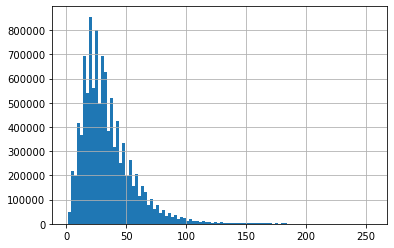

In [81]:
df[df['text_tokens_len'].apply(lambda x: x < 256)]['text_tokens_len'].hist(bins=100)

In [87]:
df[df['text_tokens_len'].apply(lambda x: x < 96)].shape[0] / df.shape[0]

0.9793318925092547

In [89]:
model = model.to('cpu')

In [ ]:
from datasets import load_dataset
data_files = {
    'train': r'D:\WorkFolder\data\augmentation_data_news2017\0_train.csv',
    'validation': r'D:\WorkFolder\data\augmentation_data_news2017\0_val.csv',
    'test': r'D:\WorkFolder\data\augmentation_data_news2017\0_test.csv'
}
extension = 'csv'
raw_datasets = load_dataset(extension, data_files=data_files, cache_dir=r'D:\WorkFolder\data\augmentation_data_news2017')


In [ ]:
if "train" not in raw_datasets:
    raise ValueError("--do_train requires a train dataset")
train_dataset = raw_datasets["train"]
with training_args.main_process_first(desc="train dataset map pre-processing"):
    train_dataset = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=column_names,
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on train dataset",
    )

In [ ]:
import torch

torch.cuda.is_available()

In [ ]:
print(paraphrase(some_text))

In [ ]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

In [ ]:
help(wordnet.synsets)

In [ ]:
wordnet.synsets('walking', wordnet.NOUN)

In [ ]:
wordnet.synsets('walk')

In [ ]:
wordnet.synsets('had')[0].lemma_names()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch
torch.cuda.is_available()


In [ ]:

torch.cuda.current_device()



In [ ]:

torch.cuda.device(0)


In [ ]:


torch.cuda.device_count()


In [ ]:

torch.cuda.get_device_name(0)